In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby
from collections import Counter
import seaborn as sns

In [19]:
aisles=pd.read_csv('../input/market-basket-analysis/aisles.csv')
departments=pd.read_csv('../input/market-basket-analysis/departments.csv')
orders=pd.read_csv('../input/market-basket-analysis/orders.csv')
products=pd.read_csv('../input/market-basket-analysis/products.csv')
sample_submission=pd.read_csv('../input/market-basket-analysis/sample_submission.csv')
order_products__prior=pd.read_csv('../input/market-basket-analysis/order_products__prior.csv')
order_products__train=pd.read_csv('../input/market-basket-analysis/order_products__train.csv')

In [3]:
orders['days_since_prior_order']=orders['days_since_prior_order'].fillna(-1)

In [ ]:
#Merging  train order and prior orders first (to check)

Dataset_orders = pd.concat([order_products__prior, order_products__train]).sort_values(by=['order_id'])

In [ ]:
#Concatenating with other DFs

Dataset_orders = pd.merge(left = Dataset_orders, right = products,
                             left_on='product_id', right_on='product_id').sort_values(by=['order_id']).reset_index(drop=True)
Dataset_orders = pd.merge(left = Dataset_orders, right = aisles,
                             left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)
Dataset_orders = pd.merge(left = Dataset_orders, right = departments,
                             left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)
prior_train_orders = pd.merge(left = Dataset_orders, right = orders,
                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)

In [5]:
df_order_products = prior_train_orders.copy()
product_count = df_order_products.groupby('product_id').size()
df_order_products['count'] = df_order_products['product_id'].map(product_count).astype('uint32')

In [6]:
product_dict = dict(zip(products['product_id'], products['product_name']))
product_dict_inv = dict(zip(products['product_name'], products['product_id']))

In [7]:
top_products = df_order_products['product_name'].value_counts()[:100]
top_products = pd.DataFrame(top_products).reset_index()
top_products.columns = ['name', 'count']
top_products['id'] = top_products['name'].map(product_dict_inv)
top_products['Baskets_Percentage'] = (top_products['count'] / orders.shape[0]) * 100
top_products = top_products.sort_values('Baskets_Percentage', ascending=False)

In [8]:
top_products.head(10)

,name,count,id,Baskets_Percentage
0,Banana,491291,24852,14.360686
1,Bag of Organic Bananas,394930,13176,11.544005
2,Organic Strawberries,275577,21137,8.055256
3,Organic Baby Spinach,251705,21903,7.357465
4,Organic Hass Avocado,220877,47209,6.456347
5,Organic Avocado,184224,47766,5.384961
6,Large Lemon,160792,47626,4.700032
7,Strawberries,149445,16797,4.368354
8,Limes,146660,26209,4.286947
9,Organic Whole Milk,142813,27845,4.174497


In [9]:
all_products = df_order_products['product_name'].value_counts()
all_products = pd.DataFrame(all_products).reset_index()
all_products.columns = ['name', 'count']
all_products['product_id'] = all_products['name'].map(product_dict_inv)
all_products['Pop_Orders_Percentage'] = (all_products['count'] / orders.shape[0]) * 100

pct_order_dict = pd.Series(all_products['Pop_Orders_Percentage'].values,index=all_products['product_id']).to_dict()

### EDA

In [10]:
Columns = ['user_id', 'order_id', 'add_to_cart_order', 'product_id', 'product_name', 'reordered', 'aisle_id', 'aisle', 'department_id',
           'department', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
           'days_since_prior_order']

prior_train_orders = prior_train_orders[Columns]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Product Name')

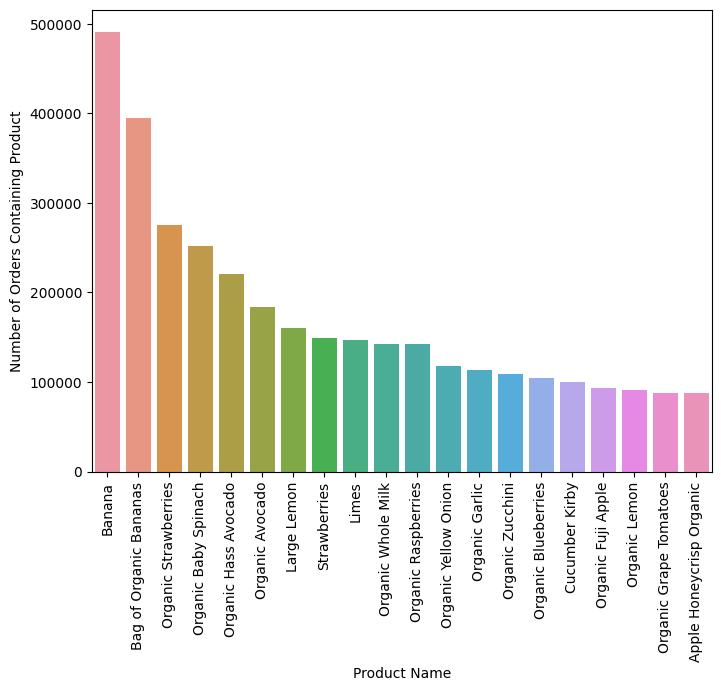

In [11]:
top_20_prods = top_products[:20]
f, ax = plt.subplots(figsize=(8, 6))
plt.xticks(rotation='vertical')
sns.barplot(top_20_prods['name'], top_20_prods['count'])
plt.ylabel('Number of Orders Containing Product')
plt.xlabel('Product Name')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Aisle Name')

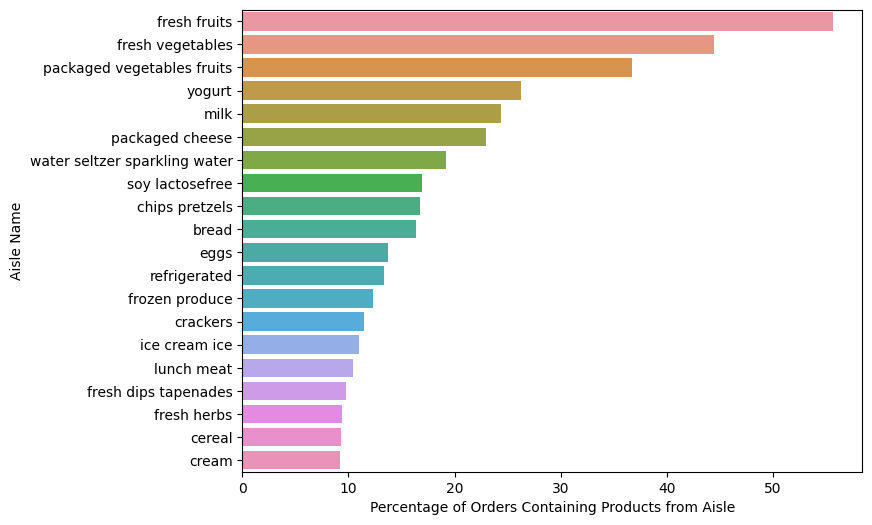

In [12]:
total_orders = len(set(prior_train_orders.order_id))
top_aisles = pd.merge(
    left=prior_train_orders.groupby('aisle_id')['order_id'].apply(lambda x: len(x.unique())).reset_index(),
    right=prior_train_orders[['aisle_id', 'aisle']].drop_duplicates(),
    how='inner',
    on='aisle_id'
).sort_values(['order_id'], ascending=False)[:20]

plt.figure(figsize=(8, 6))
sns.barplot(top_aisles.order_id / total_orders * 100,top_aisles.aisle, orient='h')
plt.xlabel('Percentage of Orders Containing Products from Aisle')
plt.ylabel('Aisle Name')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Department Name')

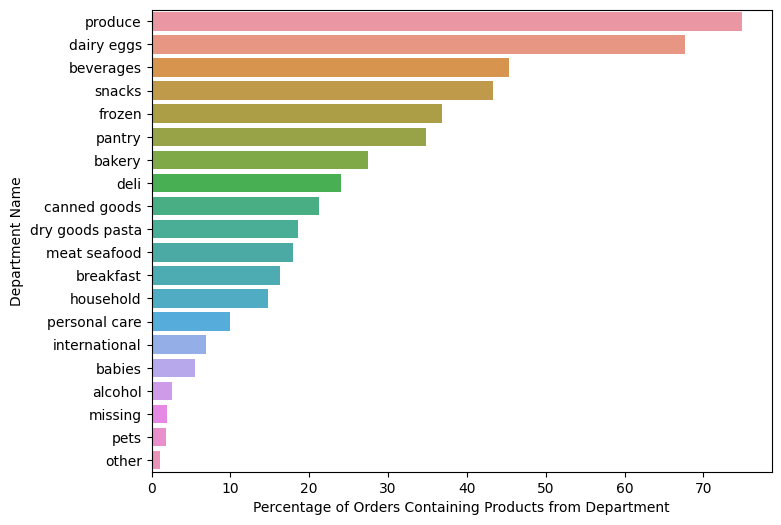

In [13]:
total_orders = len(set(prior_train_orders.order_id))
top_departments = pd.merge(
    left=prior_train_orders.groupby('department_id')['order_id'].apply(lambda x: len(x.unique())).reset_index(),
    right=prior_train_orders[['department_id', 'department']].drop_duplicates(),
    how='inner',
    on='department_id'
).sort_values(['order_id'], ascending=False)[:20]

plt.figure(figsize=(8, 6))
sns.barplot(top_departments.order_id / total_orders * 100,top_departments.department)
plt.xlabel('Percentage of Orders Containing Products from Department')
plt.ylabel('Department Name')

### User-User CF

In [14]:
def recommend_top_n_products(df, product_id, n):
    orders = df[df['product_id'] == product_id]['order_id'].tolist()
    orders_with_item = df[df['order_id'].isin(orders)]

    count_item = orders_with_item['product_name'].value_counts()[0]
    top_similar_items = orders_with_item['product_name'].value_counts()[1:n+1]

    top_similar_items = pd.DataFrame(top_similar_items)
    top_similar_items = top_similar_items.reset_index()
    top_similar_items.columns = ['name', 'count']
    
    top_similar_items['orders_percentage'] = np.round((top_similar_items['count'] / count_item) * 100, 2)
    top_similar_items['product_id'] = top_similar_items['name'].map(product_dict_inv)
    top_similar_items['orders_pop_percentage'] = top_similar_items['product_id'].map(pct_order_dict)
    top_similar_items['purchase_ratio'] = np.round(top_similar_items['orders_percentage'] / top_similar_items['orders_pop_percentage'],2)
    
    top_similar_items = top_similar_items.sort_values(by=['purchase_ratio'], ascending=False)
    top_similar_items = top_similar_items[:10]
    top_similar_items = top_similar_items.reset_index(drop=True)
    
    return top_similar_items

In [15]:
for i in range(5):
    product = top_products.iloc[i]
    recoms = recommend_top_n_products(prior_train_orders, product['id'], 5)
    print("Users who purchased \"{}\" have also purchased:".format(product['name']))
    print(', '.join(recoms['name'].tolist()))
    print("\n")

Users who purchased "Banana" have also purchased:
Organic Avocado, Strawberries, Large Lemon, Organic Baby Spinach, Organic Strawberries


Users who purchased "Bag of Organic Bananas" have also purchased:
Organic Raspberries, Organic Hass Avocado, Organic Strawberries, Organic Baby Spinach, Organic Whole Milk


Users who purchased "Organic Strawberries" have also purchased:
Organic Raspberries, Organic Hass Avocado, Bag of Organic Bananas, Organic Baby Spinach, Banana


Users who purchased "Organic Baby Spinach" have also purchased:
Organic Avocado, Organic Hass Avocado, Organic Strawberries, Bag of Organic Bananas, Banana


Users who purchased "Organic Hass Avocado" have also purchased:
Organic Raspberries, Bag of Organic Bananas, Organic Strawberries, Organic Baby Spinach, Banana




In [16]:
print("Product Name:", product_dict[30035])
recommend_top_n_products(prior_train_orders, 30035, 10)

Product Name: Natural Sweetener


,name,count,orders_percentage,product_id,orders_pop_percentage,purchase_ratio
0,Vanilla Almond Breeze Almond Milk,33,5.59,432,0.941573,5.94
1,Organic Half & Half,35,5.93,49235,2.309386,2.57
2,Organic Avocado,56,9.49,47766,5.384961,1.76
3,Organic Hass Avocado,66,11.19,47209,6.456347,1.73
4,Organic Raspberries,35,5.93,27966,4.168358,1.42
5,Organic Strawberries,64,10.85,21137,8.055256,1.35
6,Large Lemon,37,6.27,47626,4.700032,1.33
7,Banana,97,16.44,24852,14.360686,1.14
8,Bag of Organic Bananas,74,12.54,13176,11.544005,1.09
9,Organic Baby Spinach,43,7.29,21903,7.357465,0.99


In [17]:
print("Product Name:", product_dict[12623])
recommend_top_n_products(prior_train_orders, 12623, 10)

Product Name: Chicken & Rice Traditional Ground Dinner Dog Food


,name,count,orders_percentage,product_id,orders_pop_percentage,purchase_ratio
0,Original Apple Sauce,17,10.62,15840,0.007454,1424.78
1,Medium House Blend Ground Coffee,19,11.88,25494,0.020432,581.44
2,Disinfecting Wipes Fresh Scent,20,12.50,20590,0.070241,177.96
3,Hearty Grains 100% Whole Wheat English Muffins,26,16.25,3919,0.136799,118.79
4,Celery,23,14.37,19003,0.206426,69.61
5,Pink Lady (Cripps) Apple,25,15.62,42495,0.232499,67.18
6,Granny Smith Apples,27,16.88,9387,1.098073,15.37
7,Large Lemon,29,18.12,47626,4.700032,3.86
8,Organic Avocado,32,20.00,47766,5.384961,3.71
9,Banana,30,18.75,24852,14.360686,1.31


In [18]:
print("Product Name:", product_dict[39947])
recommend_top_n_products(prior_train_orders, 39947, 10)

Product Name: Blackberry Cucumber Sparkling Water


,name,count,orders_percentage,product_id,orders_pop_percentage,purchase_ratio
0,Kiwi Sandia Sparkling Water,3293,28.01,12576,0.280993,99.68
1,Curate Melon Pomelo Sparking Water,2476,21.06,45747,0.215400,97.77
2,Curate Cherry Lime Sparkling Water,1492,12.69,30353,0.274445,46.24
3,Peach Pear Flavored Sparkling Water,1278,10.87,26620,0.646930,16.80
4,Sparkling Water Grapefruit,2380,20.25,44632,2.316372,8.74
5,Lime Sparkling Water,1316,11.20,35221,1.418030,7.90
6,Banana,2155,18.33,24852,14.360686,1.28
7,Organic Baby Spinach,975,8.29,21903,7.357465,1.13
8,Organic Strawberries,933,7.94,21137,8.055256,0.99
9,Bag of Organic Bananas,1240,10.55,13176,11.544005,0.91
